In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
print(sys.executable)


/home/onizuka/Documents/Project M1/venv/bin/python3.10


In [4]:
data= pd.read_csv('final_data.csv')
data.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI_14',
       'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'PROC_9', 'EMA_10', 'EMA_30',
       'Pct_Change', 'Log_Returns', 'Volatility_10', 'Volatility_30',
       'Future_Close', 'Price_Change', 'Signal'],
      dtype='object')

## Split Data into Training and Testing Sets

In [5]:
# Define the list of features
features = ['RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30', 
            'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 
            'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns', 
            'Volatility_10', 'Volatility_30']

# Define the features (X)
X = data[features]

# Define the target variable (y)
y = data['Signal']


In [6]:
y = y.replace({2: 1})  # Replace '2' with '1'


In [7]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

##  Feature Scaling


In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform testing data
X_test_scaled = scaler.transform(X_test)

In [9]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

X_train_scaled shape: (8700, 15)
y_train shape: (8700,)


## LightGboost

In [10]:
from lightgbm import LGBMClassifier
from sklearn.base import is_classifier

# Initialize LightGBM model
model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Check if the model is a classifier
print(is_classifier(model))  # Should return True

True


In [11]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Perform cross-validation
cv_results = lgb.cv(
    params={
        'objective': 'binary',
        'metric': 'binary_logloss'  # Use binary_logloss instead of binary_error
    },
    train_set=lgb.Dataset(X_train_scaled, label=y_train),
    num_boost_round=100,
    nfold=5,
    stratified=True,
    shuffle=True
)

# Step 4: Get binary log loss
if 'valid binary_logloss-mean' in cv_results:
    binary_logloss_mean = np.mean(cv_results['valid binary_logloss-mean'])
    print("Cross-Validation Binary Logloss:", binary_logloss_mean)
else:
    print("'valid binary_logloss-mean' not found in cv_results.")

# If you want to calculate accuracy manually, train the model separately
final_model = lgb.LGBMClassifier(objective='binary', random_state=42)
final_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Num

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Hyperparameter

In [12]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the model
model = LGBMClassifier(objective='binary', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] 

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Numb

/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: F

[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386
[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4713, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677155 -> initscore=0.740729
[LightGBM] [Info] Start training from score 0.740729


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4714, number of negative: 2246
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677299 -> initscore=0.741386
[LightGBM] [Info] Start training from score 0.741386


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5892, number of negative: 2808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8700, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677241 -> initscore=0.741123
[LightGBM] [Info] Start training from score 0.741123
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 100}
Best Score: 0.7673563218390804


##  Rebuild the model with Hyperparameters 

In [13]:
# Train the model with the best parameters
best_model = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=100, objective='binary', random_state=42)
best_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data with Tuned Parameters: {accuracy}")


[LightGBM] [Info] Number of positive: 5892, number of negative: 2808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 8700, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677241 -> initscore=0.741123
[LightGBM] [Info] Start training from score 0.741123


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy on Test Data with Tuned Parameters: 0.7894252873563219


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


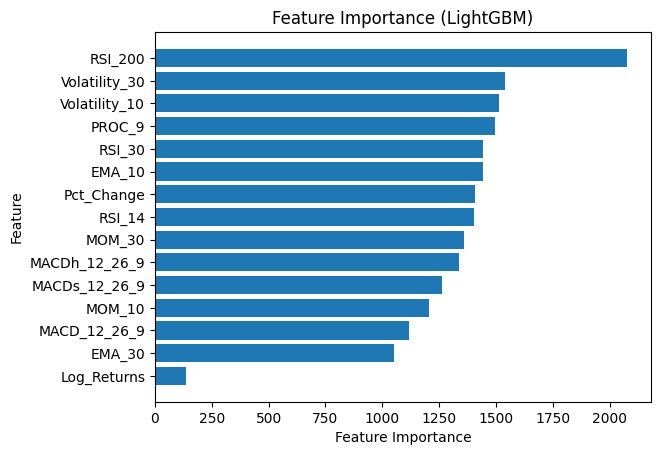

In [14]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importances = best_model.feature_importances_
features = X.columns

# Sort and plot
sorted_idx = feature_importances.argsort()
plt.barh(features[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (LightGBM)")
plt.show()


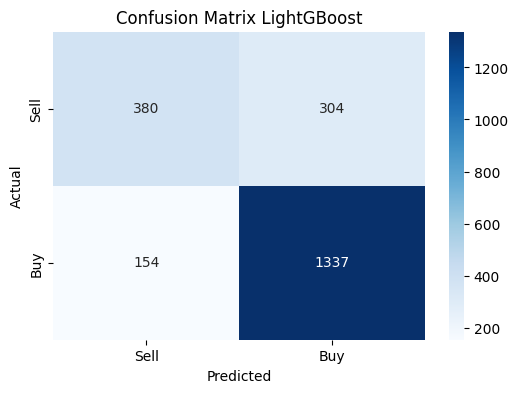

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix LightGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# 2. XGBoost Model


In [16]:
import xgboost as xgb
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


In [17]:
# Step 1: Define the list of features and target variable
features = [
    'RSI_14', 'RSI_30', 'RSI_200', 'MOM_10', 'MOM_30',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'PROC_9', 'EMA_10', 'EMA_30', 'Pct_Change', 'Log_Returns',
    'Volatility_10', 'Volatility_30'
]
X = data[features]
y = data['Signal'].replace({2: 1})  # Map '2' to '1' for binary classification


In [18]:
# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [19]:
# Step 3: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
# Step 4: Define the Optuna optimization function
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
    }
    
    # Perform cross-validation using xgb.cv
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=10,
        seed=42,
        verbose_eval=False
    )
    
    # Return the mean of the test logloss
    return cv_results['test-logloss-mean'].min()


In [21]:
# Step 5: Run Optuna optimization
study = optuna.create_study(direction='minimize', study_name="XGBoost Hyperparameter Tuning")
study.optimize(objective, n_trials=50)  # Adjust n_trials for more or fewer experiments

# Step 6: Display the best hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2025-01-17 20:31:52,944] A new study created in memory with name: XGBoost Hyperparameter Tuning
[I 2025-01-17 20:32:09,247] Trial 0 finished with value: 0.5341253164581868 and parameters: {'booster': 'dart', 'eta': 0.035243364923932846, 'max_depth': 10, 'min_child_weight': 3.807962609804012, 'subsample': 0.7583540661903392, 'colsample_bytree': 0.9653207631800116, 'lambda': 0.010914655537687267, 'alpha': 0.19502359634429847}. Best is trial 0 with value: 0.5341253164581868.
[I 2025-01-17 20:32:19,397] Trial 1 finished with value: 0.5585298010835359 and parameters: {'booster': 'dart', 'eta': 0.017480490806513024, 'max_depth': 10, 'min_child_weight': 6.728697987224763, 'subsample': 0.8439206365595926, 'colsample_bytree': 0.5560587603043154, 'lambda': 0.40314176078528097, 'alpha': 0.023741347625568426}. Best is trial 0 with value: 0.5341253164581868.
[I 2025-01-17 20:32:27,942] Trial 2 finished with value: 0.5573643816951875 and parameters: {'booster': 'dart', 'eta': 0.032775402804839204

Best Hyperparameters: {'booster': 'gbtree', 'eta': 0.1686620481836618, 'max_depth': 10, 'min_child_weight': 1.1815286614813103, 'subsample': 0.971581897421733, 'colsample_bytree': 0.8973623981283936, 'lambda': 1.0182160431676457, 'alpha': 0.055466571100172654}


In [22]:
# Step 7: Train the final model with the best hyperparameters
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False  # Avoid deprecation warning
})
final_model = xgb.XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train_scaled, y_train)


/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:36:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(alpha=0.055466571100172654, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8973623981283936, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.1686620481836618, eval_metric='logloss', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1.0182160431676457,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=1.1815286614813103, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [23]:
# Step 8: Evaluate the model on the test set
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Test Accuracy: 0.7802298850574713

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.54      0.61       698
           1       0.81      0.89      0.85      1477

    accuracy                           0.78      2175
   macro avg       0.75      0.72      0.73      2175
weighted avg       0.77      0.78      0.77      2175



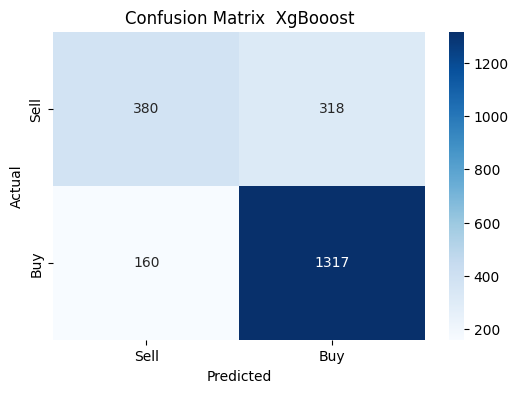

In [24]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  XgBooost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Random Forest Classifier

In [25]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss


def objectiveRD(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    # Créer le modèle RandomForest
    model = RandomForestClassifier(**params, random_state=42)
    
    # Évaluation avec validation croisée
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
    
    return -np.mean(scores)  # Minimiser la log loss

# Étape d'optimisation avec Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objectiveRD, n_trials=50)

[I 2025-01-17 20:36:04,689] A new study created in memory with name: no-name-24deb107-1fc9-4fb9-9802-5b817b1beabe
[I 2025-01-17 20:36:18,922] Trial 0 finished with value: 0.769008950178757 and parameters: {'n_estimators': 96, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.769008950178757.
[I 2025-01-17 20:36:23,780] Trial 1 finished with value: 0.5457119537615623 and parameters: {'n_estimators': 107, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.5457119537615623.
[I 2025-01-17 20:36:41,285] Trial 2 finished with value: 3.247216882462486 and parameters: {'n_estimators': 78, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: 0.5457119537615623.
[I 2025-01-17 20:36:44,716] Trial 3 finished with value: 0.5491227320435754 and 

In [26]:
# Récupérer les meilleurs hyperparamètres trouvés par Optuna
best_params = study.best_params

# Ajouter les paramètres fixes nécessaires pour RandomForestClassifier
best_params.update({
    'random_state': 42
})

# Créer et entraîner le modèle final avec les meilleurs hyperparamètres
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, max_depth=19, max_features='log2',
                       min_samples_leaf=3, min_samples_split=4,
                       random_state=42)

In [27]:
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.7986206896551724

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.52      0.63       698
           1       0.81      0.93      0.86      1477

    accuracy                           0.80      2175
   macro avg       0.79      0.73      0.74      2175
weighted avg       0.80      0.80      0.79      2175



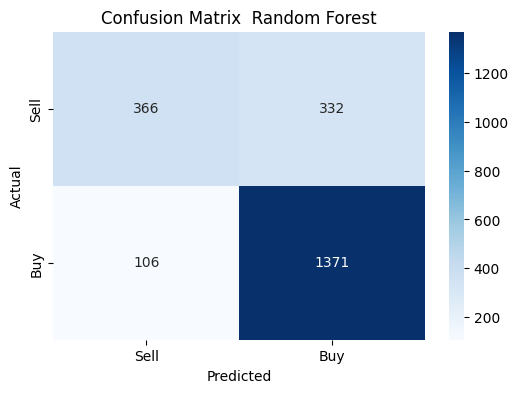

In [28]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

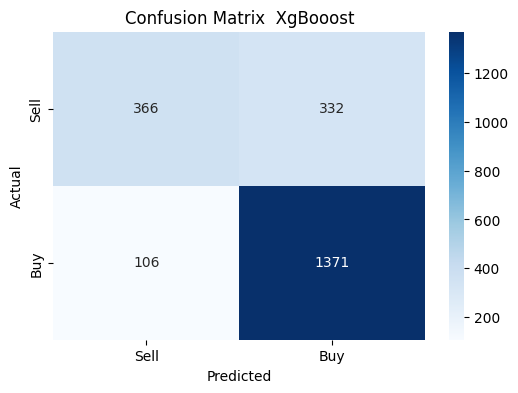

In [29]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sell', 'Buy'], yticklabels=['Sell', 'Buy'])
plt.title('Confusion Matrix  XgBooost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()